In [161]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import skimage.io as io
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import zipfile

In [162]:
tf.autograph.set_verbosity(0)

In [163]:
def n_filters(stage, fmap_base, fmap_max, fmap_decay):
  """Get the number of filters in a convolutional layer."""
  return int(min(fmap_max, fmap_base / 2.0 ** (stage * fmap_decay)))


def pixelwise_feature_norm(x, epsilon=1e-8):
  """Pixelwise feature normalization for the output of convolutional layers."""
  return x / K.sqrt(
      K.mean(K.square(x), axis=len(x.shape)-1, keepdims=True) + epsilon)


def layer_init_stddev(shape, gain=np.sqrt(2)):
  """Get the He initialization scaling term."""
  fan_in = np.prod(shape[:-1])
  return gain / np.sqrt(fan_in)


def Dense(x, units,
          use_wscale=False,
          gain=np.sqrt(2),
          name=None):
  """Build a densely connected layer."""
  if len(x.shape) > 2:
    x = K.reshape(x, shape=(-1, np.prod(x.shape[1:])))
  stddev = layer_init_stddev([x.shape[1], units], gain=gain)
  if use_wscale:
    weight_init = tf.keras.initializers.RandomNormal()
    x = tf.keras.layers.Dense(units, activation=None,
                              kernel_initializer=weight_init,
                              use_bias=False,
                              name=name)(x)
    x = tf.keras.layers.Lambda(
        lambda x: x * K.constant(stddev, dtype='float32'))(x)
    return x
  weight_init = tf.keras.initializers.RandomNormal(0.0, stddev)
  return tf.keras.layers.Dense(units, activation=None,
                               kernel_initializer=weight_init,
                               use_bias=False,
                               name=name)(x)


class Bias(tf.keras.layers.Layer):
  """Bias layer for applying the bias after weight scaling."""
  def __init__(self, shape, *args, **kwargs):
    super(Bias, self).__init__(*args, **kwargs)
    self.shape = shape
    self._config = {'shape': shape}
    self.b = self.add_weight('bias',
                             shape=shape,
                             initializer='zeros',
                             trainable=True)

  def call(self, x):
    """Call method for functional API."""
    return x + self.b


def Conv2D(x, filters, kernel,
           gain=np.sqrt(2),
           use_wscale=False,
           name=None,
           **unused_kwargs):
  """Build a 2D convolutional layer."""
  stddev = layer_init_stddev([kernel, kernel, x.shape[1], filters], gain=gain)
  if use_wscale:
    weight_init = tf.keras.initializers.RandomNormal()
    x = tf.keras.layers.Conv2D(filters, kernel,
                               strides=(1, 1),
                               padding='same',
                               kernel_initializer=weight_init,
                               use_bias=False,
                               activation=None,
                               name=name)(x)
    x = tf.keras.layers.Lambda(
        lambda x: x * K.constant(stddev, dtype='float32'))(x)
    return x
  weight_init = tf.keras.initializers.RandomNormal(0.0, stddev)
  return tf.keras.layers.Conv2D(filters, kernel,
                                strides=(1, 1),
                                padding='same',
                                kernel_initializer=weight_init,
                                use_bias=False,
                                activation=None,
                                name=name)(x)



class Lerp(tf.keras.layers.Layer):
  """A linear interpolation layer for fading in higher resolutions."""

  def __init__(self, t, *args, **kwargs):
    super(Lerp, self).__init__(*args, **kwargs)
    self.t = t

  def call(self, a, b, *args, **kwargs):
    """Call method for functional API."""
    return a + (b - a) * self.t


def resolution_label(res_log2):
  """Create an image resolution label."""
  return '{}x{}'.format(1 << res_log2, 1 << res_log2)

# THE GENERATOR

In [164]:

def G(latent_size=None,  # Dimensionality of latent space.
      fmap_base=8192,
      fmap_max=512,  # Max filters in each conv layer.
      fmap_decay=1.0,
      normalize_latents=True,  # Pixelwise normalize latent vector.
      use_wscale=True,  # Scale the weights with He init at runtime.
      use_pixel_norm=True,  # Use pixelwise normalization.
      use_leaky_relu=True,  # True = use LeakyReLU, False = use ReLU.
      num_channels=3,  # Number of output channels.
      resolution=64,  # Resolution of the output.
      **unused_kwargs):
  """Build the generator networks for each size."""
  if latent_size is None:
    latent_size = min(fmap_base, fmap_max)

  partial_nfilters = lambda n: n_filters(n, fmap_base, fmap_max, fmap_decay)

  opts = {
      'use_wscale': use_wscale,
      'use_pixel_norm': use_pixel_norm,
      'use_leaky_relu': use_leaky_relu,
  }

  # We can set the value of this during training with a callback.
  alpha = K.variable(0.0, dtype='float32', name='alpha')

  models = {}
  resolution_log2 = int(np.log2(resolution))

  for max_res_log2 in range(2, resolution_log2 + 1):
    latents_in = tf.keras.layers.Input(shape=(latent_size,), name='latents_in')
    x = latents_in
    if normalize_latents:
      x = pixelwise_feature_norm(x)
    x = G_block(x, 2, partial_nfilters, **opts)
    img = toRGB(x, num_channels, **opts, name='4x4_to_rgb')

    if max_res_log2 == 2:
      models['4x4'] = tf.keras.models.Model(latents_in, img)
      continue

    img_prev = img

    for res_log2 in range(3, max_res_log2 + 1):
      x = G_block(x, res_log2, partial_nfilters, **opts)
      if res_log2 == (max_res_log2 - 1):
        img_prev = toRGB(x, num_channels, **opts,
                         name='{}_to_rgb'.format(resolution_label(res_log2)))
      if res_log2 == max_res_log2:
        img = toRGB(x, num_channels, **opts,
                    name='{}_to_rgb'.format(resolution_label(res_log2)))
        img = Lerp(alpha)(tf.keras.layers.UpSampling2D()(img_prev), img)

    label = resolution_label(max_res_log2)
    models[label] = tf.keras.models.Model(latents_in, [img, img_prev])

  return models, alpha


def G_block(x, res_log2, n_filters,
            use_pixel_norm=False,
            use_wscale=False,
            use_leaky_relu=False,
            **unused_kwargs):
  """Build a block of the generator."""
  pn = lambda x: pixelwise_feature_norm(x) if use_pixel_norm else x
  act = (tf.keras.layers.LeakyReLU() if use_leaky_relu
         else tf.keras.layers.Activation('relu'))
  
  nf = n_filters(res_log2 - 1)

  if res_log2 == 2:
    # Start with dense layer.
    units = nf << 4
    x = Dense(x, units, gain=np.sqrt(2)/4, use_wscale=use_wscale,
              name='G_dense_head')
    x = K.reshape(x, [-1, 4, 4, nf])
    x = Bias([1, 1, nf], name='G_dense_head_bias')(x)
    x = pn(act(x))
    # Then the first convolutional layer.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale, name='4x4_conv')
    x = Bias([1, 1, nf], name='4x4_conv_bias')(x)
    return pn(act(x))
  else:
    res_label = resolution_label(res_log2)
    # Upsample the input.
    x = tf.keras.layers.UpSampling2D()(x)

    # Now 2 convolutional layers.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv0'.format(res_label))
    x = Bias([1, 1, nf], name='{}_conv0_bias'.format(res_label))(x)
    x = pn(act(x))

    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv1'.format(res_label))
    x = Bias([1, 1, nf], name='{}_conv1_bias'.format(res_label))(x)
    return pn(act(x))
  return x

# TO-DO: Adapt it to a 2/band or Multispectral function
def toRGB(x, channels,
          use_pixel_norm=False,
          use_wscale=False,
          use_leaky_relu=False,
          name=None,
          **unused_kwargs):
  """Convert a 4D tensor into the RGB color space."""
  pn = lambda x: pixelwise_feature_norm(x) if use_pixel_norm else x
  act = (tf.keras.layers.LeakyReLU() if use_leaky_relu
         else tf.keras.layers.Activation('relu'))
  x = Conv2D(x, filters=channels, kernel=1, gain=1, use_wscale=use_wscale,
             name=name)
  bias_name = None if name is None else name + '_bias'
  x = Bias([1, 1, channels], name=bias_name)(x)
  return tf.keras.layers.Activation('sigmoid')(x)

# THE DISCRIMINATOR

In [165]:
def D(num_channels=3,  # Number of channels images have.
      resolution=64,  # Max image resolution.
      fmap_base=8192,
      fmap_max=512,  # Max filters in each conv layer.
      fmap_decay=1.0,
      use_wscale=True,  # Scale the weights with He init at runtime.
      mbstd_group_size=4, # Group size for minibatch stddev layer.
      **unused_kwargs):
  """Build the discriminator networks for each size."""
  partial_nfilters = lambda n: n_filters(n, fmap_base, fmap_max, fmap_decay)
  resolution_log2 = int(np.log2(resolution))
  opts = {
      'use_wscale': use_wscale,
      'mbstd_group_size': mbstd_group_size,
  }

  # We can set the value of this during training with a callback.
  alpha = K.variable(0.0, dtype='float32', name='alpha')
  img_ins = {
      resolution_label(res_log2): tf.keras.layers.Input(
          shape=(1 << res_log2, 1 << res_log2, num_channels))
      for res_log2 in range(2, resolution_log2 + 1)
  }
  outputs = {}

  for max_res_log2 in range(2, resolution_log2 + 1):
    label = resolution_label(max_res_log2)
    x = img_ins[label]
    x = fromRGB(x, filters=partial_nfilters(max_res_log2 - 1),
                name='{}_from_rgb'.format(label), **opts)
    for res_log2 in range(max_res_log2, 2, -1):
      x = D_block(x, res_log2, partial_nfilters, **opts)
      if res_log2 == max_res_log2:
        prev_label = resolution_label(res_log2 - 1)
        prev_img = img_ins[prev_label]
        y = fromRGB(prev_img, partial_nfilters(res_log2 - 2),
                    name='{}_from_rgb'.format(prev_label), **opts)
        x = Lerp(alpha)(y, x)
    outputs[label] = D_block(x, 2, partial_nfilters, **opts)

  models = {}
  for res_log2 in range(2, resolution_log2 + 1):
    label = resolution_label(res_log2)
    ins = [img_ins[label]]
    if res_log2 > 2:
      ins.append(img_ins[resolution_label(res_log2 - 1)])
    models[label] = tf.keras.models.Model(ins, outputs[label])
  
  return models, alpha


def fromRGB(x, filters,
            use_wscale=False,
            name=None,
            **unused_kwargs):
  """First covolutional layer after an RGB layer."""
  x = Conv2D(x, filters=filters, kernel=1, use_wscale=use_wscale, name=name)
  bias_name = None if name is None else name + '_bias'
  x = Bias([1, 1, filters], name=bias_name)(x)
  return tf.keras.layers.LeakyReLU()(x)


def D_block(x, res_log2, n_filters,
            mbstd_group_size=4,
            use_wscale=False,
            **unused_kwargs):
  """Build a block of the discriminator conv net."""
  act = tf.keras.layers.LeakyReLU()
  nf = n_filters(res_log2 - 1)
  if res_log2 == 2:
    # Apply minibatch stddev layer.
    x = MinibatchStddev(x, mbstd_group_size)

    # Then a convolutional layer.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale, name='4x4_conv')
    x = Bias([1, 1, nf], name='4x4_conv_bias')(x)
    x = act(x)

    # Now we add the dense head to the discriminator.
    nf = n_filters(0)
    x = tf.keras.layers.Flatten(data_format='channels_last')(x)
    x = Dense(x, nf, use_wscale=use_wscale, name='D_dense_head')
    x = Bias([nf], name='D_dense_head_bias')(x)
    x = act(x)
    x = Dense(x, 1, gain=1, use_wscale=use_wscale, name='D_logit')
    x = Bias([1], name='D_logit_bias')(x)
  else:
    label = resolution_label(res_log2)

    # First convolutional layer.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv0'.format(label))
    x = Bias([1, 1, nf], name='{}_conv0_bias'.format(label))(x)
    x = act(x)

    # Second convolutional layer.
    nf = n_filters(res_log2 - 2)
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv1'.format(label))
    x = Bias([1, 1, nf], name='{}_conv1_bias'.format(label))(x)
    x = act(x)
    
    # And downscale.
    x = Downscale2D(x)
  return x


def MinibatchStddev(x, group_size):
  """Contatenate the stddev of the minibatch to the output of a conv layer."""
  y = K.reshape(x, [group_size, -1, *x.shape[1:]])
  y = K.cast(y, 'float32')
  y -= K.mean(y, axis=0, keepdims=True)
  y = K.mean(K.square(y), axis=0)
  y = K.cast(y, x.dtype)
  y = K.tile(y, [group_size, 1, 1, 1])
  return K.concatenate([x, y], axis=1)


def Downscale2D(x):
  """Downscale layer scales an image down 2x."""
  return tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='valid',
                                          data_format='channels_last')(x)

# DEFINING THE ADVERSARIAL NETWORK AND TRANING OBJECTIVE

In [166]:
class WGANGP(tf.keras.models.Model):
  """
  A single WGAN-GP network.

  This implements the training objective for a single resolution
  of ProGAN. This model is applied iteratively over each resolution
  with a fresh optimizer. The motivation of ProGAN is to treat each
  resolution as an entirely different learning task, and uses the
  pretrained lower layers for transfer learning.

  In order to properly implement the gradient penalty loss term
  with TensorFlow 2.x, we need to extend the Keras model with
  our own custom training method. Since we have to use this model
  extension, we can also encapsulate the "fading in" the next
  resolutions.
  
  """

  def __init__(self,
               resolution,
               G,
               D,
               G_optimizer,
               D_optimizer,
               batch_size,
               latent_size,
               G_alpha=None,
               D_alpha=None,
               gradient_weight=10.0,
               D_repeat=1,
               *args, **kwargs):
    super(WGANGP, self).__init__(*args, **kwargs)
    self.resolution = resolution
    self.G = G
    self.D = D
    self.G_optimizer = G_optimizer
    self.D_optimizer = D_optimizer
    self.batch_size = batch_size
    self.latent_size = latent_size
    self.gradient_weight = gradient_weight

    self.G_alpha = G_alpha
    self.D_alpha = D_alpha

    self.D_repeat = D_repeat

  def compute_D_loss(self, real_imgs):
    """Compute discriminator loss terms."""

    # Generate the image at lower resolution for layer fading.
    latents_in = np.random.normal(size=(self.batch_size, self.latent_size))
    if self.resolution > 4:
      fake_imgs = self.G(latents_in)
      interp_imgs = [self.interpolate_imgs(real_imgs[i], fake_imgs[i])
                     for i in range(2)]
    else:
      fake_imgs = [self.G(latents_in)]
      interp_imgs = [self.interpolate_imgs(real_imgs[0], fake_imgs[0])]
    
    real_pred = self.D(real_imgs)
    fake_pred = self.D(fake_imgs)

    real_loss = tf.reduce_mean(real_pred)
    fake_loss = -tf.reduce_mean(fake_pred)
    gp_loss = self.gradient_penalty(interp_imgs)

    return real_loss, fake_loss, gp_loss

  def interpolate_imgs(self, real_img, fake_img):
    """Interpolate real and fake images for GP loss calculation."""
    w = tf.random.uniform([self.batch_size, 1, 1, 1], 0.0, 1.0)
    return (w * real_img) + ((1.0 - w) * fake_img)

  def gradient_penalty(self, interp_imgs):
    """Compute gradient penalty loss."""
    with tf.GradientTape() as tape:
      tape.watch(interp_imgs)
      interp_pred = self.D(interp_imgs)
    grads = tape.gradient(interp_pred, interp_imgs)[0]
    ddx = K.sqrt(K.sum(tf.square(grads), axis=np.arange(1, len(grads.shape))))
    loss = tf.reduce_mean(tf.square(1.0 - ddx))
    return self.gradient_weight * loss

  def compute_G_loss(self):
    """Compute G loss."""
    latents_in = np.random.normal(size=(self.batch_size, self.latent_size))

    # For fading in the new layer.
    if self.resolution > 4:
      fake_imgs = self.G(latents_in)
    else:
      fake_imgs = [self.G(latents_in)]

    fake_pred = self.D(fake_imgs)
    return tf.reduce_mean(fake_pred)

  def compute_D_gradients(self, real_imgs, print_loss=False):
    """Compute the discriminator loss gradients."""
    with tf.GradientTape() as tape:
      D_loss_real, D_loss_fake, D_loss_gp = self.compute_D_loss(real_imgs)
      D_loss = D_loss_real + D_loss_fake + D_loss_gp

    if print_loss:
      print('D Loss: R: {:04f} F: {:04f} GP: {:04f}'.format(
          D_loss_real, D_loss_fake, D_loss_gp))
    
    return tape.gradient(D_loss, self.D.trainable_variables)

  def compute_G_gradients(self, print_loss=False):
    """Compute the generator loss gradients."""
    with tf.GradientTape() as tape:
      G_loss = self.compute_G_loss()

    if print_loss:
      print('G Loss: {:04f}'.format(G_loss))

    return tape.gradient(G_loss, self.G.trainable_variables)

  def train_on_batch(self, X_batch, alpha=None, print_loss=False):
    """Train on a single batch of data."""
    if alpha is not None:
      K.set_value(self.G_alpha, alpha)
      K.set_value(self.D_alpha, alpha)

    for _ in range(self.D_repeat):
      D_grads = self.compute_D_gradients(X_batch, print_loss)
      self.D_optimizer.apply_gradients(zip(D_grads, self.D.trainable_variables))
    
    G_grads = self.compute_G_gradients(print_loss)
    self.G_optimizer.apply_gradients(zip(G_grads, self.G.trainable_variables))


def average_gradients(all_grads):
  """Take the average of gradients over multiple batches."""
  grad_table = {}
  for grads in all_grads:
    for i, g in enumerate(grads):
      try:
        grad_table[i].append(g)
      except:
        grad_table[i] = [g]

  return [tf.reduce_mean(tf.stack(grad_table[i]), axis=0)
          for i in sorted(grad_table.keys())]

In [167]:
class ProGAN:
  """Collection of WGAN-GP networks for each resolution model."""

  def __init__(self,
               # ProGAN parameters
               batch_size=64,
               learning_rate=0.001,
               learning_rate_decay=0.8,
               gradient_weight=10.0,
               D_repeat=1,
               # Generator parameters
               latent_size=None,
               normalize_latents=True,
               use_leaky_relu=True,
               # Discriminator parameters
               mbstd_group_size=4,
               # Shared parameters
               fmap_base=8192,
               fmap_max=512,
               fmap_decay=1.0,
               num_channels=3,
               resolution=128,
               use_pixel_norm=True,
               use_wscale=True,
               **unused_kwargs):
    if latent_size is None:
      latent_size = min(fmap_base, fmap_max)

    self.latent_size = latent_size
    self.batch_size = batch_size
    self.G, self.alpha_G = G(latent_size=latent_size,
                             fmap_base=fmap_base,
                             fmap_max=fmap_max,
                             fmap_decay=fmap_decay,
                             normalize_latents=normalize_latents,
                             use_wscale=use_wscale,
                             use_pixel_norm=use_pixel_norm,
                             use_leaky_relu=use_leaky_relu,
                             num_channels=num_channels,
                             resolution=resolution)
    self.D, self.alpha_D = D(num_channels=num_channels,
                             resolution=resolution,
                             fmap_base=fmap_base,
                             fmap_max=fmap_max,
                             fmap_decay=fmap_decay,
                             use_pixel_norm=use_pixel_norm,
                             use_wscale=use_wscale,
                             mbstd_group_size=mbstd_group_size)
    
    opt = lambda lr: tf.keras.optimizers.Adam(lr, beta_1=0.0,
                                              beta_2=0.99, epsilon=1e-8)
    self.models = {
        resolution_label(res_log2): WGANGP(
            1 << res_log2,
            self.G[resolution_label(res_log2)],
            self.D[resolution_label(res_log2)],
            opt(learning_rate * (learning_rate_decay ** (res_log2 - 2))),
            opt(learning_rate * (learning_rate_decay ** (res_log2 - 2))),
            batch_size, 
            latent_size,
            self.alpha_G,
            self.alpha_D,
            gradient_weight,
            D_repeat)
        for res_log2 in range(2, int(np.log2(resolution)) + 1)
    }

  def transfer_previous_resolution_weights(self, resolution):
    """Load the weights from the model for the previous resolution."""
    cur_res_log2 = int(np.log2(resolution))
    prev_label = resolution_label(cur_res_log2 - 1)
    cur_label = resolution_label(cur_res_log2)

    # Copy model weights

    prev_weights_G = {}
    for layer in self.G[prev_label].layers:
      w = layer.get_weights()
      if w:
        prev_weights_G[layer.name] = w
    
    prev_weights_D = {}
    for layer in self.D[prev_label].layers:
      w = layer.get_weights()
      if w:
        prev_weights_D[layer.name] = w

    total_params = 0

    for layer in self.G[cur_label].layers:
      if layer.name in prev_weights_G:
        w = np.array(prev_weights_G[layer.name])
        layer.set_weights(prev_weights_G[layer.name])
        total_params += np.prod(w.shape)

    for layer in self.D[cur_label].layers:
      if layer.name in prev_weights_D:
        w = np.array(prev_weights_D[layer.name])
        layer.set_weights(w)
        total_params += np.prod(w.shape)

    print('Copied {} parameters to the higher resolution model.'.format(
        total_params))
    
  def save(self, resolution, checkpoint_path):
    """Save model weights and optimizer state."""
    resolution_log2 = int(np.log2(resolution))
    label = resolution_label(resolution_log2)

    self.G[label].save_weights(os.path.join(checkpoint_path, 'G_weights.ckpt'))
    self.D[label].save_weights(os.path.join(checkpoint_path, 'D_weights.ckpt'))

    model = self.models[label]
    pickle.dump(model.G_optimizer,
                open(os.path.join(checkpoint_path, 'G_opt.pkl'), 'wb'))
    pickle.dump(model.D_optimizer,
                open(os.path.join(checkpoint_path, 'D_opt.pkl'), 'wb'))

  def load(self, resolution, checkpoint_path, load_optimizer_state=False):
    """Load model weights and optimizer state."""
    resolution_log2 = int(np.log2(resolution))
    label = resolution_label(resolution_log2)

    self.G[label].load_weights(os.path.join(checkpoint_path, 'G_weights.ckpt'))
    self.D[label].load_weights(os.path.join(checkpoint_path, 'D_weights.ckpt'))
    
    if load_optimizer_state:
      model = self.models[label]
      model.G_optimizer = pickle.load(
          open(os.path.join(checkpoint_path, 'G_opt.pkl'), 'rb'))
      model.D_optimizer = pickle.load(
          open(os.path.join(checkpoint_path, 'D_opt.pkl'), 'rb'))

In [168]:
def load_dataset():
    train = pd.read_json('./data/train.json')
    train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

    icebergs = train[train.is_iceberg==1].sample(n=300,random_state=123)
    ships = train[train.is_iceberg==0].sample(n=300,random_state=456)

    # Convert DataFrame to NumPy array
    # Convert DataFrame columns to NumPy arrays
    band1_array = np.array([np.array(x) for x in icebergs['band_1']])
    band2_array = np.array([np.array(x) for x in icebergs['band_2']])

    # Convert the array to TensorFlow tensor
    image_tensors = tf.convert_to_tensor(np.stack([band1_array, band2_array], axis=-1))

    # Create a tf.data.Dataset from the image tensors
    dataset = tf.data.Dataset.from_tensor_slices(image_tensors)
    return dataset

In [169]:
def augment(x, image_size):
  """Data augmentation"""
  x = tf.image.random_flip_left_right(x)
  return tf.cast(x, tf.float32) / 255.0


@tf.autograph.experimental.do_not_convert
def images_dataset(image_size, batch_size, dataset=None, interpolation='nearest'):
    """Create a training set of img_size x img_size photographs."""
    def preprocess(image):
        image = tf.reshape(image, (75, 75, 2))
        image = tf.expand_dims(image, axis=-1)
        image = tf.image.resize(image, (image_size, image_size), method=interpolation)
        # Apply other preprocessing steps if needed
        return image
    if dataset is None:
       dataset = load_dataset()
    dataset = dataset.map(lambda x: tf.convert_to_tensor(x))

    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset
     

In [170]:
# Read the JSON file
import pandas as pd


train = pd.read_json('./data/train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

icebergs = train[train.is_iceberg==1].sample(n=300,random_state=123)
ships = train[train.is_iceberg==0].sample(n=300,random_state=456)

# Convert DataFrame to NumPy array
# Convert DataFrame columns to NumPy arrays
band1_array = np.array([np.array(x) for x in icebergs['band_1']])
band2_array = np.array([np.array(x) for x in icebergs['band_2']])

# Convert the array to TensorFlow tensor
image_tensors = tf.convert_to_tensor(np.stack([band1_array, band2_array], axis=-1))

# Create a tf.data.Dataset from the image tensors
dataset = tf.data.Dataset.from_tensor_slices(image_tensors)


In [171]:
def plot_real_images(resolution,
                     n_to_show=20,
                     n_rows=5,
                     figsize=(8, 10)):
  """Plot a set of real images.""" 
  X_train = images_dataset(resolution, n_to_show, dataset).as_numpy_iterator()
  
  X_batch = next(X_train)
  fig = plt.figure(figsize=figsize)

  for i, x in enumerate(X_batch):
    ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
    ax.axis('off')
    ax.imshow(x[:, :, 0], cmap='gray', interpolation='antialiased')

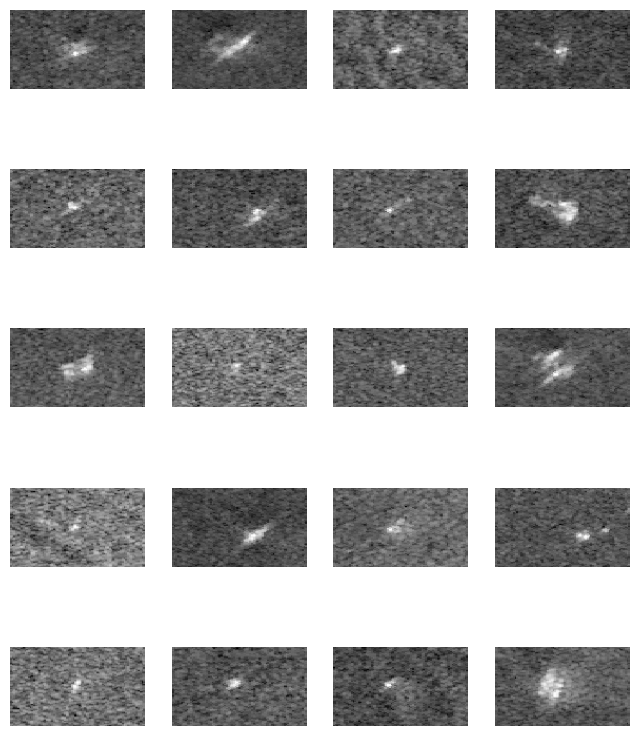

In [172]:
plot_real_images(128)


In [178]:
def training_datasets(resolution_log2, batch_size):
  """Build the training datasets up to a maximum resolution."""
  if resolution_log2 == 2:
    return [images_dataset(4, batch_size).as_numpy_iterator()]
  size = 1 << resolution_log2
  datasets = [images_dataset(size, batch_size)]
  datasets.append(datasets[0].map(
      lambda x: tf.image.resize(x, (size >> 1, size >> 1))))
  return [ds.as_numpy_iterator() for ds in datasets]


def training_data(resolution, batch_size):
  """Build a generator for training the discriminator."""
  resolution_log2 = int(np.log2(resolution))
  datasets = training_datasets(resolution_log2, batch_size)
  while True:
    try:
      data = tuple([next(ds) for ds in datasets])
      if len(data[0]) != batch_size:
        datasets = training_datasets(resolution_log2, batch_size)
        data = tuple([next(ds) for ds in datasets])
      yield data
    except StopIteration:
      datasets = training_datasets(resolution_log2, batch_size)

In [174]:
def train_progan(gan, resolution,
                 total_kimg=1000,  # 1000s of images to show D.
                 transition_kimg=500,  # 1000s of images to fade in new layer.
                 checkpoint_path=None,  # Path to save weights.
                 print_every_n_batches=25,
                 alpha_min=0.0,  # Min and max for the mixing factor.
                 alpha_max=1.0,
                 save_every_n_batches=1000,
                 snapshot_every_n_batches=500,
                 **unused_kwargs):
  """Train ProGAN at a specific resolution."""
  batch_size = gan.batch_size

  total_img = 0
  n_batches = (total_kimg * 1000) // batch_size
  X_train = training_data(resolution, batch_size)

  resolution_log2 = int(np.log2(resolution))
  label = resolution_label(resolution_log2)
  alpha_batch = None

  for i in range(1, n_batches + 1):
    total_img += batch_size

    if resolution > 4 and transition_kimg != 0:
      alpha_batch = alpha_min
      alpha_batch += ((alpha_max - alpha_min)
                      * float(total_img) / (transition_kimg * 1000))
      alpha_batch = max(alpha_min, alpha_batch)
      alpha_batch = min(alpha_max, alpha_batch)
    elif resolution > 4:
      alpha_batch = 1.0

    X_batch = next(X_train)
    if alpha_batch is not None:
      X_batch = (fade_new_resolution(X_batch[0], alpha_batch), X_batch[1])
    
    print_loss = (i % print_every_n_batches) == 0
    if print_loss:
      print('Batch: {} / {}'.format(i, n_batches))
      if alpha_batch is not None:
        print('Alpha: {}'.format(alpha_batch))

    gan.models[label].train_on_batch(X_batch,
                                     alpha=alpha_batch,
                                     print_loss=print_loss)

    if (i % save_every_n_batches == 0 or i == n_batches) and checkpoint_path:
      print('Saving weights...')
      gan.save(resolution, checkpoint_path)
      print('Done.')
    
    # Every snaphot_every_n_batches batches we plot a snapshot of the model's
    # progress. Since evaluating the performance based on loss has been
    # difficult while I was experimenting with hyperparameters on my own.
    # The best way to evaluate the model is sampling G at each distribution.
    if i % snapshot_every_n_batches == 0:
      plot_generated_images(gan, resolution, alpha=alpha_batch)
      plt.show()


def plot_generated_images(gan,
                          resolution,
                          latents_in=None,
                          n_to_show=20,
                          n_rows=5,
                          figsize=(8, 10),
                          alpha=1.0):
  """Plot images made by a generator."""
  resolution_log2 = int(np.log2(resolution))

  latents_in = np.random.normal(size=(n_to_show, gan.latent_size))
  X_batch = gan.G[resolution_label(resolution_log2)].predict(latents_in)
  if resolution > 4:
    X_batch, X_prev = X_batch

  if alpha is not None and alpha != 1.0:
    X_prev = np.array(X_prev).repeat(2, axis=1).repeat(2, axis=2)
    X_batch = (alpha * X_batch) + ((1.0 - alpha) * X_prev)
  
  fig = plt.figure(figsize=(8, 10))

  for i, x in enumerate(X_batch):
    ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
    ax.axis('off')
    ax.imshow(np.clip(np.array(x).squeeze(), 0.0, 1.0),
              interpolation='antialiased')


def fade_new_resolution(x, alpha):
  """Just-in-time preprocessing of the real images adds crossfade between levels of detail."""
  s = x.shape
  y = tf.reshape(x, [-1, s[1] // 2, 2, s[2] // 2, 2, s[3]])
  y = tf.reduce_mean(y, axis=(2, 4))
  y = tf.keras.layers.UpSampling2D()(y)
  y = tf.reshape(y, [-1, *s[1:]])
  return y + (x - y) * alpha

In [175]:
latents_test = np.random.normal(size=(64, 512))


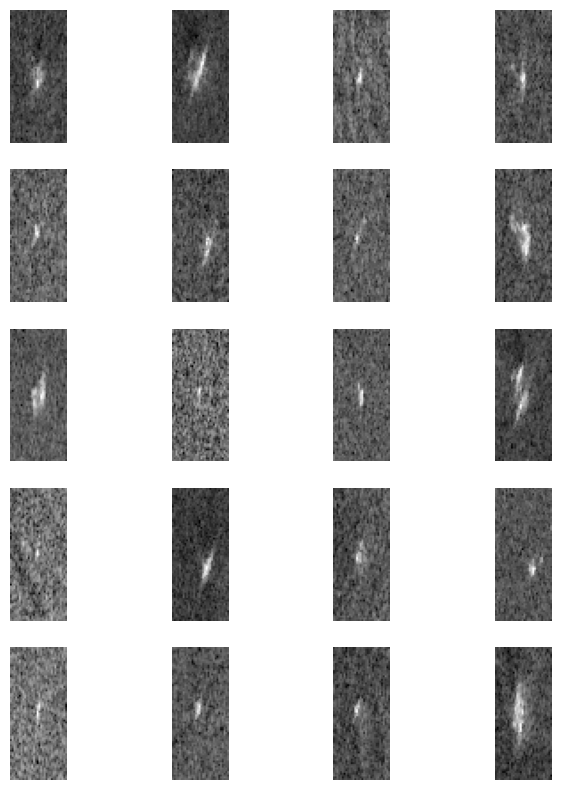

In [176]:
plot_real_images(32)


In [181]:
gan = ProGAN()
train_progan(gan, 75,
             checkpoint_path='weights/',
             transition_kimg=600,
             total_kimg=2000)

ValueError: in user code:

    File "C:\Users\flopes1\AppData\Local\Temp\ipykernel_33204\2005510799.py", line 8, in None  *
        lambda x: tf.image.resize(tf.reshape(x, (75, 75, 2)), (size >> 1, size >> 1))

    ValueError: Dimension size must be evenly divisible by 307200 but is 11250 for '{{node Reshape}} = Reshape[T=DT_DOUBLE, Tshape=DT_INT32](args_0, Reshape/shape)' with input shapes: [?,75,64,64,1], [3] and with input tensors computed as partial shapes: input[1] = [75,75,2].
